In [1]:
import keras
from keras.preprocessing import image as kimage
from keras.applications import mobilenet_v2, densenet
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import os
import time
import joblib
from sklearn.neighbors import KDTree

In [2]:
#importo la rete pre-addestrata
net = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))

In [3]:
#importo il face detector
detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

In [17]:
def rileva_faccia(img):   
    #volto da riconoscere
    img = cv.imread(img)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = detector.detectMultiScale(img_gray)
    if len(faces) == 1:
        (x,y,w,h) = faces[0]
        face = img[y:y+h, x:x+h,:]
        b,g,r = cv.split(face)
        face = cv.merge([r,g,b])
        face = cv.resize(face, (224,224))
        
        return face #se trovo un volto lo restituisco
    

In [5]:
def neural_features(img):
    #preprocessare ed estrarre le features neurali
    x = kimage.img_to_array(img)
    x = mobilenet_v2.preprocess_input(x) 
    x = np.expand_dims(x, axis=0)
    f = net.predict(x)
    return f.flatten()

In [6]:
def load_data(feature_extractor):
    #percorso per il dataset
    data_path = './people/'
    #liste dove salvare i risultati
    paths = []
    labels = []
    features = []
    for subdir in os.listdir(data_path):
        full_path = os.path.join(data_path, subdir)

        for fi,f in enumerate(sorted(os.listdir(full_path))):
            if f.endswith('.jpg'):
                cur_path = full_path + '/' + f
                face = rileva_faccia(cur_path)
                if type(face) == np.ndarray:
                    cur_features = feature_extractor(face)
                    features.append(cur_features)
                    paths.append(cur_path)
                    labels.append(subdir)
                

    features = np.array(features)
    return features, labels, paths

Comandi per salvare l'albero di ricerca e i path associati alle foto.

In [8]:
%%time
X_train, labels, paths = load_data(neural_features)

Wall time: 4h 43min 51s


In [9]:
tree = KDTree(X_train)

In [11]:
joblib.dump(tree, 'people_tree.joblib')

['people_tree2.joblib']

In [10]:
with open('people_labels.txt','w') as lab:
    for i in labels:
        lab.write(i+';')

with open('people_paths.txt','w') as pat:
    for i in paths:
        pat.write(i+';')

Caricare i file da qua:

In [7]:
tree = joblib.load('people_tree.joblib') 

In [8]:
with open('people_labels.txt','r') as labels_read:
    file=labels_read.read()
labels_people=file.split(';')
labels_people=labels_people[:-1]


with open('people_paths.txt','r') as paths_read:
    file=paths_read.read()
paths_people=file.split(';')
paths_people=paths_people[:-1]

In [19]:
def retrieve_top10(query_image, tree):
  
    query_face = rileva_faccia(query_image)
    query_features = neural_features(query_face)
    query_features = np.expand_dims(query_features, axis=0)
    plt.imshow(kimage.load_img(query_image))
    plt.axis('off')
    dists, ind = tree.query(query_features, k=10)
    paths = [paths_people[int(ind[0][i])] for i in range(10)]
    person = [labels_people[int(ind[0][i])] for i in range(10)]
    dist = dists[0]
    fig = plt.figure(figsize=(20, 30))
    
    rows = 5
    columns = 2
    
    for n in range(1,len(paths)+1):
        d = dist[n-1]
        dnorm = 1-((d-min(dist))/(max(dist) - min(dist)))
        plt.subplot(rows, columns, n)
        plt.imshow(kimage.load_img(paths[n-1]))
        plt.axis('off')
        
        plt.title(str(person[n-1])+'\n euclidean dist: '+str(round(d,2))+'\nrelative dist: '+str(round(dnorm*100,2))+'%')
    return 'Top-10 most similar faces'

In [15]:
cap = cv.VideoCapture(0)
time.sleep(3)
result, img = cap.read()
cap.release()

In [16]:
cv.imwrite("foto_test.jpg", img) 

True

'Top-10 most similar faces'

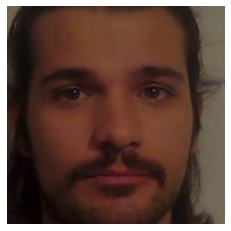

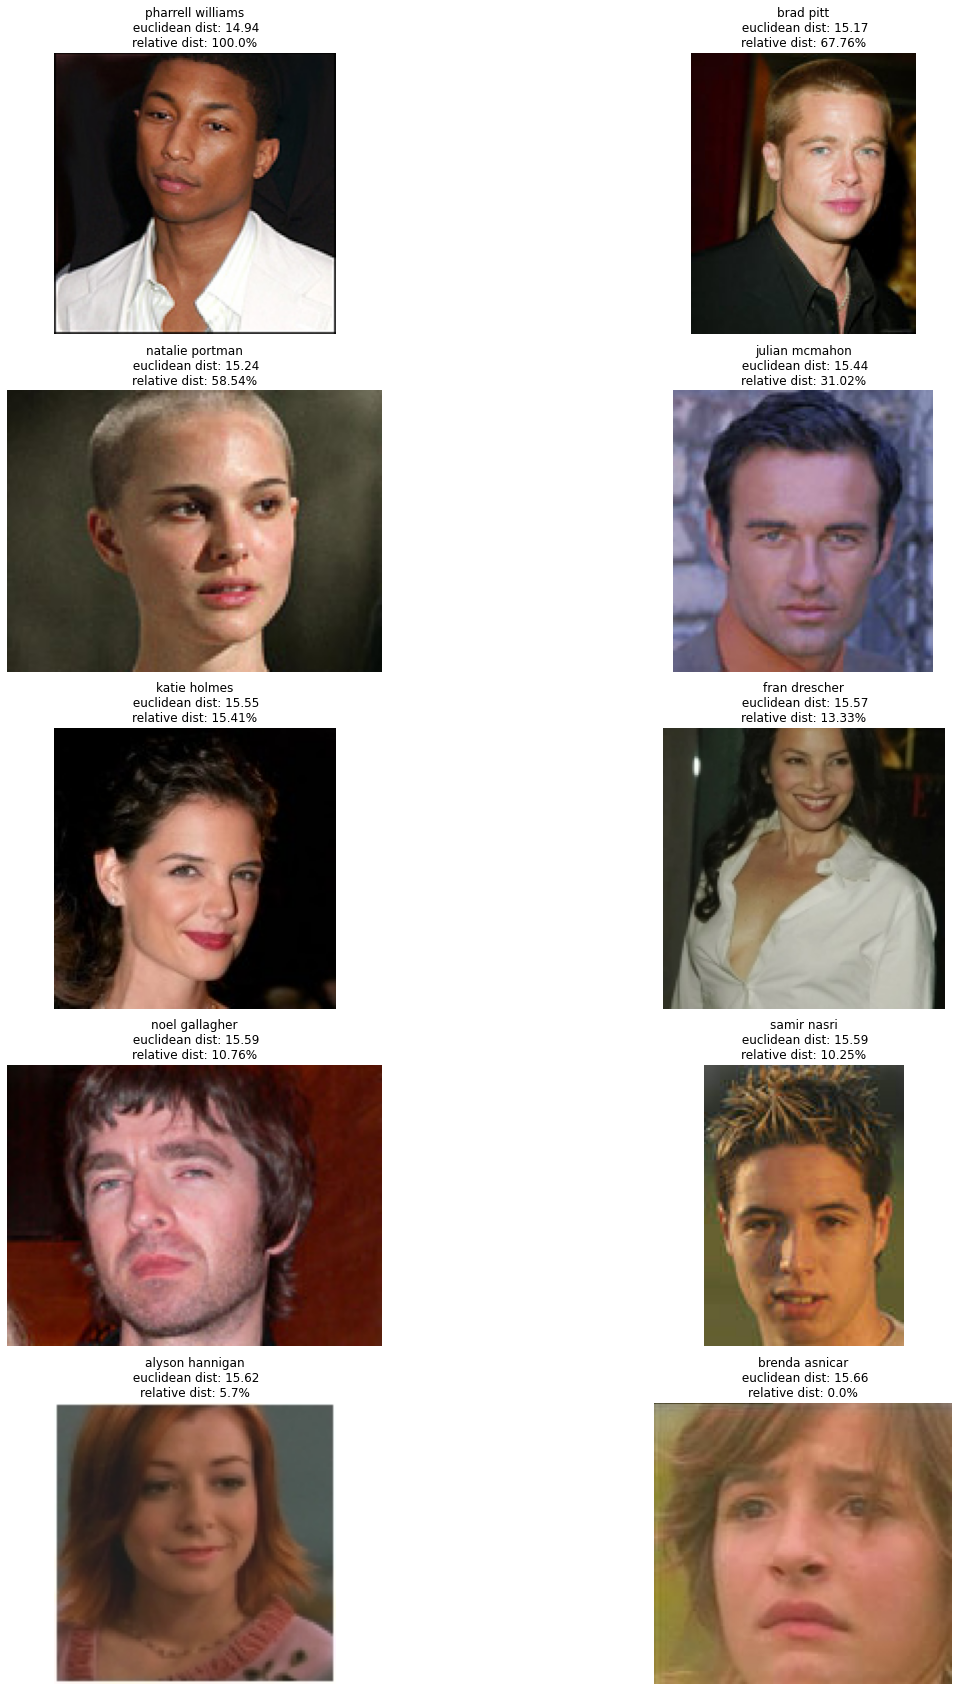

In [30]:
retrieve_top10('rob.jpg', tree)

'Top-10 most similar faces'

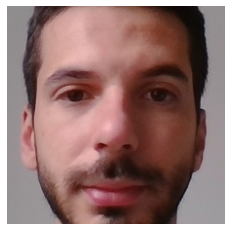

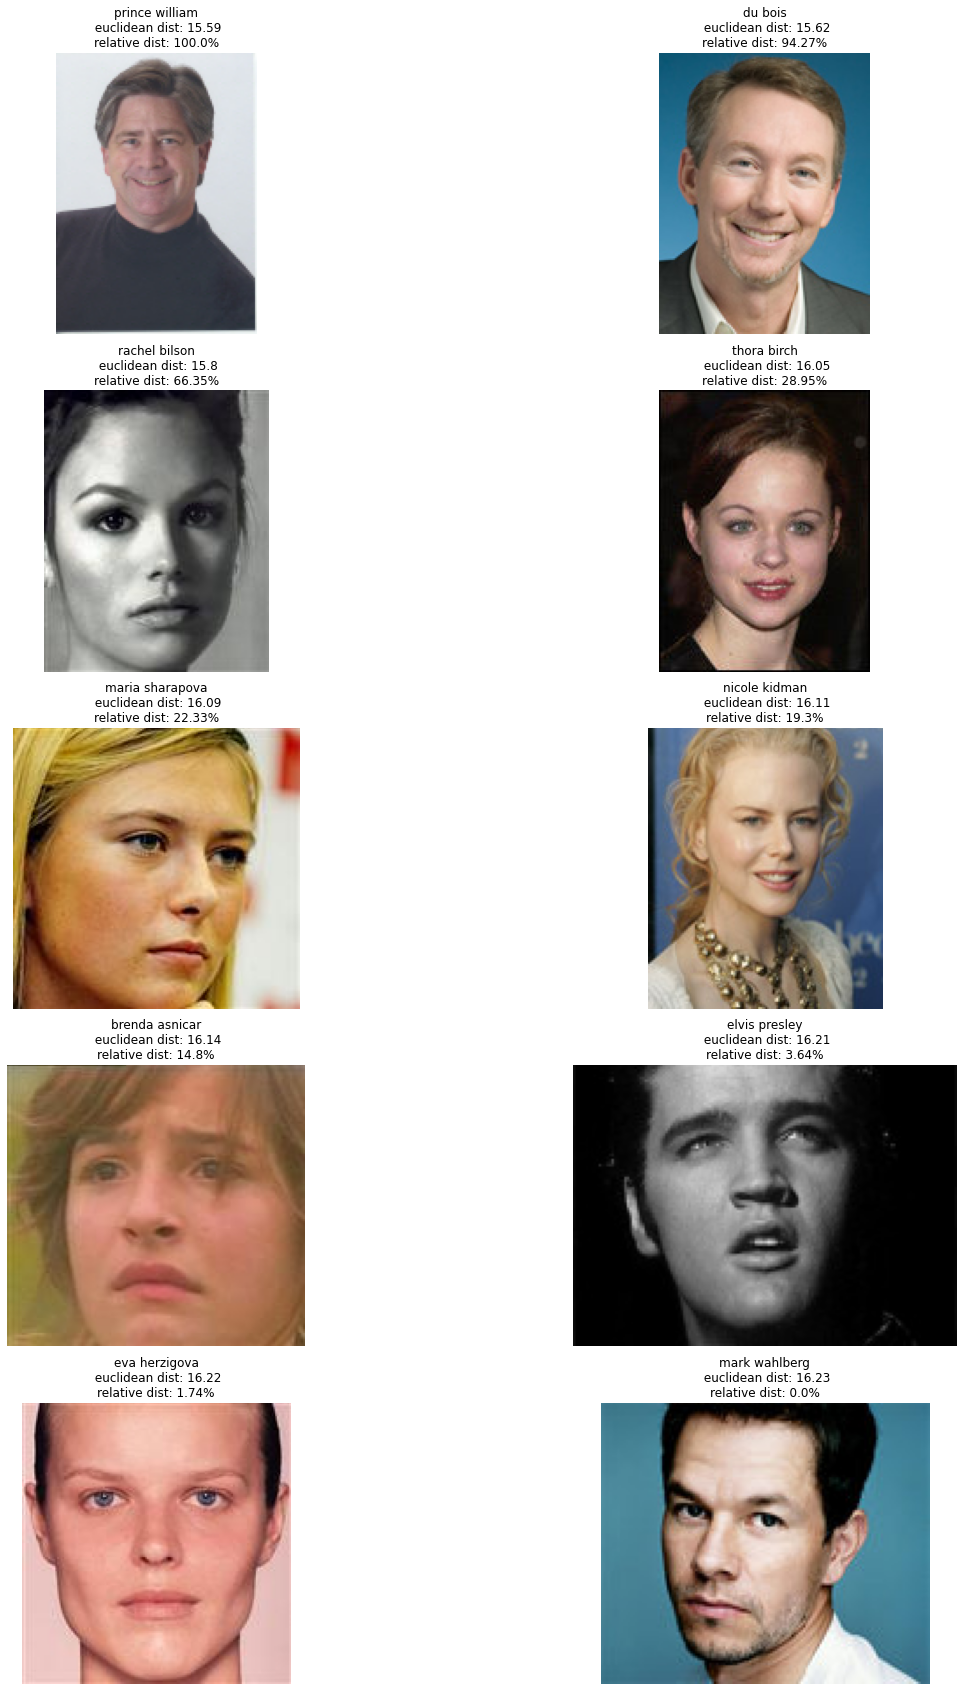

In [26]:
retrieve_top10('marco.jpg', tree)